# Download Dataset

In [ ]:
import gdown

In [ ]:
!mkdir ./dataset

In [ ]:
cd dataset

In [ ]:
# info
id1 = "1cqfcs-7XXhh_kqIUPEde-lY6I9COUsjC"
gdown.download(id=id1, quiet=False)

# Train-val zip
id2 = "1YWjUODQWwQ3_vKSytqVdF4recqBOEe72"
gdown.download(id=id2, quiet=False)

# test zip
id3 = "1diN3tNe2nR1eV3Px4gqlp6wp3XuLBwDy"
gdown.download(id=id3, quiet=False)

In [ ]:
# unzip dataset

from glob import glob
import zipfile

files = glob('*.zip')

for file in files:
    print('Unzipping:',file)

    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall('./')


In [ ]:
!rm -rf train_val.zip
!rm -rf TEST.zip

In [ ]:
cd ..

In [ ]:
# split random val and train
import os
import shutil
import random

# Define the path to the dataset
dataset_base_path = './dataset'
images_path = os.path.join(dataset_base_path, 'train_val/images')
masks_path = os.path.join(dataset_base_path, 'train_val/masks')

# Define the path for the train and val directories
train_images_path = os.path.join(dataset_base_path, 'train/images')
train_masks_path = os.path.join(dataset_base_path, 'train/masks')
val_images_path = os.path.join(dataset_base_path, 'val/images')
val_masks_path = os.path.join(dataset_base_path, 'val/masks')

# Create directories if they don't exist
for path in [train_images_path, train_masks_path, val_images_path, val_masks_path]:
    os.makedirs(path, exist_ok=True)

# Get the list of image files
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

# Shuffle and split the dataset
random.shuffle(image_files)
split_ratio = 0.9
split_index = int(len(image_files) * split_ratio)

train_files = image_files[:split_index]
val_files = image_files[split_index:]

# Move the files to the respective directories
for file in train_files:
    shutil.move(os.path.join(images_path, file), train_images_path)
    shutil.move(os.path.join(masks_path, file.replace('.jpg', '.bmp')), train_masks_path)

for file in val_files:
    shutil.move(os.path.join(images_path, file), val_images_path)
    shutil.move(os.path.join(masks_path, file.replace('.jpg', '.bmp')), val_masks_path)


# Import libraries

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import random

import torchvision.transforms.functional as TF
import cv2

import torch.nn as nn
import torch.nn.functional as F


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_transform=None, augmentation_factor=10, apply_augmentation=False):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_transform = target_transform
        self.augmentation_factor = augmentation_factor
        self.apply_augmentation = apply_augmentation
        self.images = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images) * self.augmentation_factor

    def __getitem__(self, idx):
        original_idx = idx % len(self.images)
        augment = idx >= len(self.images)

        image_path = os.path.join(self.images_dir, self.images[original_idx])
        mask_path = os.path.join(self.masks_dir, self.images[original_idx].replace('.jpg', '.bmp'))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.apply_augmentation:
            image, mask = self.apply_transforms(image, mask)

        if self.transform is not None:
            image = self.transform(image)

        # Convert mask to class labels
        mask = self.convert_mask(mask)

        # Convert the NumPy array back to a PIL Image for target_transform
        mask = Image.fromarray(mask.astype(np.uint8))

        if self.target_transform is not None:
            mask = self.target_transform(mask)
        else:
            mask = torch.tensor(mask, dtype=torch.long)
        return image, mask


    def apply_transforms(self, image, mask):
        # Random horizontal flipping with 50% probability
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random rotation with 50% probability
        if random.random() > 0.5:
            angle = random.uniform(-20, 20)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, fill=0)

        # Random affine transformations (shear, zoom, width/height shift) with 50% probability
        if random.random() > 0.5:
            translate = (random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05))
            scale = random.uniform(1 - 0.05, 1 + 0.05)
            shear = random.uniform(-0.05, 0.05)
            image = TF.affine(image, angle=0, translate=translate, scale=scale, shear=shear)
            mask = TF.affine(mask, angle=0, translate=translate, scale=scale, shear=shear, fill=0)

        return image, mask

    def convert_mask(self, mask):
        mapping = {
            (0, 0, 0): 0,
            (0, 0, 255): 1,
            (0, 255, 0): 2,
            (0, 255, 255): 3,
            (255, 0, 0): 4,
            (255, 0, 255): 5,
            (255, 255, 0): 6,
            (255, 255, 255): 7
        }
        mask = np.array(mask)
        class_map = np.zeros(mask.shape[:2], dtype=np.int32)
        for rgb, idx in mapping.items():
            class_map[(mask == rgb).all(axis=2)] = idx
        return class_map


In [ ]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((160, 160), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])

# Load the training dataset with augmentation
train_dataset = SegmentationDataset('dataset/train/images', 'dataset/train/masks',
                                   transform=transform, target_transform=target_transform,
                                   augmentation_factor=3, apply_augmentation=True)

# Load the validation dataset without augmentation
val_dataset = SegmentationDataset('dataset/val/images', 'dataset/val/masks',
                                  transform=transform, target_transform=target_transform,
                                  augmentation_factor=1, apply_augmentation=False)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)



/tmp/ipykernel_114118/1102774159.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((160, 160), interpolation=Image.NEAREST),


In [ ]:
for i , l in train_loader:
    print(i.shape)
    print(l.shape)
    break

torch.Size([32, 3, 160, 160])
torch.Size([32, 160, 160])


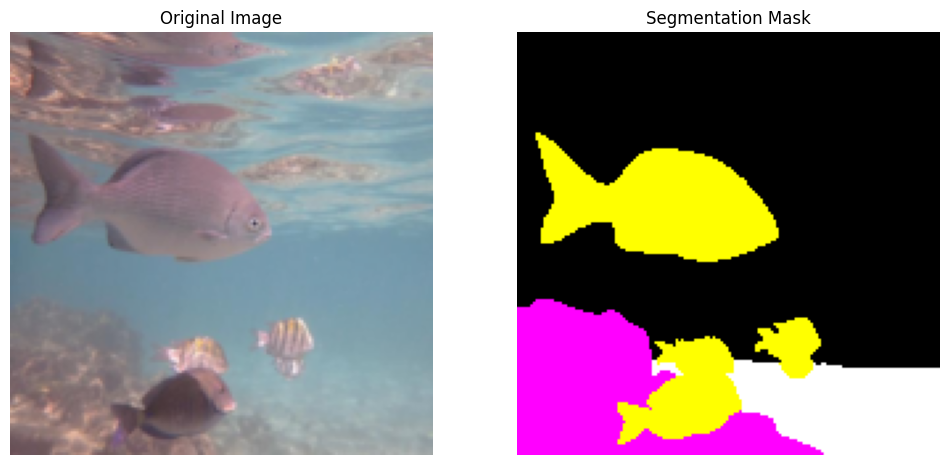

In [ ]:
# Function to convert a torch tensor to a numpy array
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to reverse the class labels to RGB
def labels_to_rgb(mask):
    label_colors = {
        0: [0, 0, 0],      # Background waterbody
        1: [0, 0, 255],    # Human divers
        2: [0, 255, 0],    # Plants/sea-grass
        3: [0, 255, 255],  # Wrecks/ruins
        4: [255, 0, 0],    # Robots/instruments
        5: [255, 0, 255],  # Reefs and invertebrates
        6: [255, 255, 0],  # Fish and vertebrates
        7: [255, 255, 255] # Sand/sea-floor (& rocks)
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb_image[mask == label] = color
    return rgb_image

# Get a random batch from the train_loader
images, masks = next(iter(train_loader))

# Choose a random image and mask from the batch
idx = random.randint(0, images.shape[0] - 1)
image = to_numpy(images[idx])
mask = to_numpy(masks[idx])

# Normalize image for visualization
image = np.transpose(image, (1, 2, 0))  # Change from CHW to HWC format
# Reversing the normalization
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)

# Convert labels to RGB
mask_rgb = labels_to_rgb(mask)

# Plot the image and the mask separately
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_rgb)  # Display the mask separately
plt.title('Segmentation Mask')
plt.axis('off')

plt.show()

# Implement PSPnet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.models import mobilenet_v2


class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes, out_channels):
        super(PyramidPoolingModule, self).__init__()
        self.pools = nn.ModuleList([nn.AdaptiveAvgPool2d(output_size=size) for size in pool_sizes])
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False) for size in pool_sizes])
        self.batch_norms = nn.ModuleList([nn.BatchNorm2d(out_channels) for _ in pool_sizes])
        self.relus = nn.ModuleList([nn.ReLU(inplace=True) for _ in pool_sizes])

    def forward(self, x):
        size = x.size()[2:]
        cat = [x]
        for pool, conv, bn, relu in zip(self.pools, self.convs, self.batch_norms, self.relus):
            p = pool(x)
            p = F.interpolate(p, size=size, mode='bilinear', align_corners=False)
            p = conv(p)
            p = bn(p)
            p = relu(p)
            cat.append(p)
        return torch.cat(cat, dim=1)

class PSPNet(nn.Module):
    def __init__(self, num_classes):
        super(PSPNet, self).__init__()
        # Use the pre-trained MobileNetV2 model features
        mobilenet = mobilenet_v2(pretrained=False)
        self.backbone = mobilenet.features

        # The output channels of the backbone's last layer
        backbone_out_channels = 1280  # This is specific to MobileNetV2 architecture

        # Pyramid Pooling Module
        self.ppm = PyramidPoolingModule(in_channels=backbone_out_channels,
                                        pool_sizes=[1, 2, 3, 6],
                                        out_channels=256)

        # The final convolution layer to get the logits for each class
        # The output channels of PPM will be in_channels + out_channels * len(pool_sizes)
        self.final_conv = nn.Conv2d(backbone_out_channels + 256 * 4,
                                    num_classes, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.ppm(x)
        x = self.final_conv(x)
        x = F.interpolate(x, size=(160, 160), mode='bilinear', align_corners=False)
        return x


In [ ]:
def calculate_miou(preds, labels, num_classes):
    iou_list = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()  # Intersection
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection  # Union
        if union == 0:
            iou = float('nan')  # Avoid zero division
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return np.nanmean(iou_list)  # Return the average IoU

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
n_channels = 3
n_classes = 8
lr = 0.0001
momentum = 0.5
n_epochs = 60

# Model, optimizer, and loss function
model = PSPNet(n_classes).to(device)

# Create the Adam optimizer with momentum
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(momentum, 0.999))
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

criterion = nn.CrossEntropyLoss()

Using device: cuda:1


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from tqdm import tqdm
# Initialize the best validation mIoU
best_val_miou = 0.0


# Define the directory and filename for saving the model
model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)
# Define the filename for saving the best model
best_model_filename = 'best_PSPNet.pth'

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_miou = []
val_miou = []

early_stop_patience = 8
early_stop_counter = 0

# Training loop
for epoch in range(n_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_iou = 0.0

    for images, masks in tqdm(train_loader):
        # Move data to device
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_iou += calculate_miou(outputs, masks, n_classes)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_iou = total_train_iou / len(train_loader)
    train_losses.append(avg_train_loss)
    train_miou.append(avg_train_iou)

    scheduler.step()

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            # Move data to device
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            total_val_iou += calculate_miou(outputs, masks, n_classes)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_iou = total_val_iou / len(val_loader)
    val_losses.append(avg_val_loss)
    val_miou.append(avg_val_iou)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Train mIoU: {avg_train_iou}, Val Loss: {avg_val_loss}, Val mIoU: {avg_val_iou}')

    # Check if the current validation mIoU is the best one
    if avg_val_iou > best_val_miou:
        print(f"New best validation mIoU: {avg_val_iou} at epoch {epoch+1}")
        best_val_miou = avg_val_iou

        # Save the model
        best_save_path = os.path.join(model_save_path, best_model_filename)
        torch.save(model.state_dict(), best_save_path)
        print(f"Best model saved to {best_save_path}")

        early_stop_counter = 0
    else:
        # Increment early stopping counter
        early_stop_counter += 1

    # Check if training should be stopped early
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation mIoU for {early_stop_patience} consecutive epochs.")
        break

100%|██████████| 133/133 [06:07<00:00,  2.77s/it]


Epoch 1, Train Loss: 1.4042575072525139, Train mIoU: 0.12747435862640114, Val Loss: 1.3043703317642212, Val mIoU: 0.1546941719382888
New best validation mIoU: 0.1546941719382888 at epoch 1
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:05<00:00,  2.75s/it]


Epoch 2, Train Loss: 1.2704404233989859, Train mIoU: 0.14970731557670636, Val Loss: 1.1870783925056458, Val mIoU: 0.17049847658933814
New best validation mIoU: 0.17049847658933814 at epoch 2
Best model saved to models/best_Unet.pth


100%|██████████| 133/133 [06:03<00:00,  2.73s/it]


Epoch 3, Train Loss: 1.2140667254763438, Train mIoU: 0.16730879832927356, Val Loss: 1.136982548236847, Val mIoU: 0.18541839395630227
New best validation mIoU: 0.18541839395630227 at epoch 3
Best model saved to models/best_Unet.pth


 44%|████▍     | 59/133 [02:42<03:20,  2.71s/it]

In [ ]:
print("avg_train_loss :" , train_miou[-1] )
print( "best_val_miou :",best_val_miou)

avg_train_loss : 0.5550190330704431
best_val_miou : 0.40764676870261135


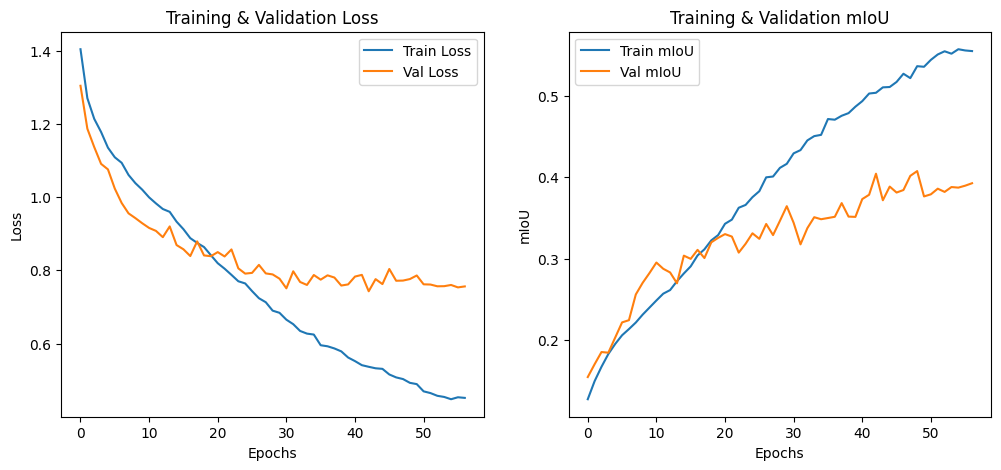

In [ ]:
plt.figure(figsize=(12, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation mIoU
plt.subplot(1, 2, 2)
plt.plot(train_miou, label='Train mIoU')
plt.plot(val_miou, label='Val mIoU')
plt.title('Training & Validation mIoU')
plt.xlabel('Epochs')
plt.ylabel('mIoU')
plt.legend()

plt.show()

# Test Model

In [ ]:
# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((160, 160), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))
])


# Load the validation dataset without augmentation
test_dataset = SegmentationDataset('dataset/TEST/images', 'dataset/TEST/masks',
                                  transform=transform, target_transform=target_transform,
                                  augmentation_factor=1, apply_augmentation=False)


# Create data loaders
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=1)

/tmp/ipykernel_114118/4143619823.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((160, 160), interpolation=Image.NEAREST),


In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
n_channels = 3
n_classes = 8

# Model, optimizer, and loss function
model = PSPNet(n_classes).to(device)

Using device: cuda:1


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Define the path to the saved model
saved_model_path = 'models/best_PSPNet.pth'

# Make sure the model is in evaluation mode
model.load_state_dict(torch.load(saved_model_path))
model.eval()
print("Model Loaded")

Model Loaded


In [ ]:
total_test_iou = 0.0

# Run the model on the test data
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        total_test_iou += calculate_miou(outputs, masks, n_classes)

avg_test_iou = total_test_iou / len(test_loader)

print(f'Test mIoU: {avg_test_iou}')

Test mIoU: 0.35681125414923776


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random


# Function to convert a torch tensor to a numpy array
def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

# Function to reverse the class labels to RGB
def labels_to_rgb(mask):
    label_colors = {
        0: [0, 0, 0],      # Background waterbody
        1: [0, 0, 255],    # Human divers
        2: [0, 255, 0],    # Plants/sea-grass
        3: [0, 255, 255],  # Wrecks/ruins
        4: [255, 0, 0],    # Robots/instruments
        5: [255, 0, 255],  # Reefs and invertebrates
        6: [255, 255, 0],  # Fish and vertebrates
        7: [255, 255, 255] # Sand/sea-floor (& rocks)
    }
    rgb_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb_image[mask == label] = color
    return rgb_image

# Get 10 random images and masks from the dataset
num_samples = 10
selected_images = []
selected_masks = []

for _ in range(num_samples):
    images, masks = next(iter(test_loader))
    idx = random.randint(0, images.shape[0] - 1)
    image = to_numpy(images[idx])
    mask = to_numpy(masks[idx])

    # Normalize and transpose image
    image = np.transpose(image, (1, 2, 0))  # Change from CHW to HWC format
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)

    # Convert labels to RGB
    mask_rgb = labels_to_rgb(mask)

    selected_images.append(image)
    selected_masks.append(mask_rgb)

# Plot the images and masks
plt.figure(figsize=(25, 20))  # Adjust the size of the figure

for i in range(num_samples):
    # Plot image
    plt.subplot(5, 4, 2*i + 1)
    plt.imshow(selected_images[i])
    plt.axis('off')

    # Plot mask
    plt.subplot(5, 4, 2*i + 2)
    plt.imshow(selected_masks[i])
    plt.axis('off')

plt.tight_layout()
plt.show()